In [1]:
import os
import cv2
from torchvision import datasets
import torchvision
import torch
import imutils
from torchvision.transforms import transforms
import torchvision.models as models
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils.video import VideoStream
import torch.nn.functional as F
Image.LOAD_TRUNCATED_IMAGES = True

In [2]:
from torch import device
print("[INFO] loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=None)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 3),
    torch.nn.Softmax(dim=1)
)
model.load_state_dict(torch.load('./trained-models/best_model.pt', map_location=device))

model.to(device)
model.eval()

[INFO] loading model...


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
class_names = class_names = ['Fire', 'Neutral', 'Smoke']

def predict(image):
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    image = image.to(device)

    pred = model(image)
    probabilities = F.softmax(pred, dim=1)
    idx = torch.argmax(probabilities, dim=1).item()
    prob = probabilities[0][idx].item()*100
    prediction = class_names[idx]
    return prediction, prob

## Image

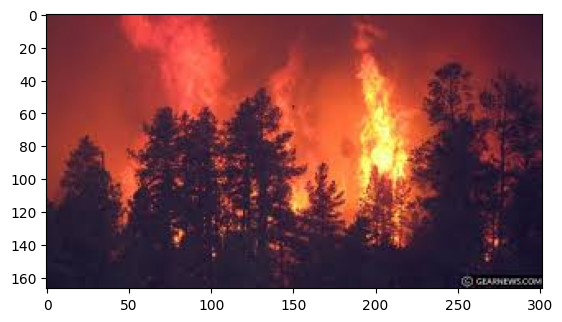

Fire 57.61168599128723


In [13]:

import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('./test-imgs/image_14.jpg')
plt.imshow(img)
plt.show()
prediction, prob = predict(img)
print(prediction, prob)

## Video

In [5]:
cap = cv2.VideoCapture(0)

while True:

    ret, image = cap.read()
    if not ret:
        print("Failed to grab frame")
        break # Exit the loop if there's a problem

    draw = image.copy()
    draw = cv2.resize(draw,(640,480))
    
    draw = transforms.ToPILImage()(draw)
    prediction, prob = predict(draw)
    
    if prediction == 'Neutral':
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.putText(image, (prediction+' '), (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    

    cv2.imshow('framename', image)
        
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()